# Bio-Signal Analysis for Smoking Prediction

## Problems

Binary Classification $\begin{cases}1&\text{smoking}\\0&\text{No smoking}\end{cases}$

Conducting analysis on bio-signals to

- Assesing health indicators : Evaluate the impact of smoking on various health indicators, such as hemoglobin, gender, and age, to better understand its health consequences

- Identinfying key health indicators affected when a person is a smoker

## Import library & load data

In [179]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install Jinja2  
# needed by dataframe.format
!pip install scipy 
# needed by kendall measurement
!pip install scikit-learn
!pip install xgboost
!pip install prettytable
!pip install imbalanced-learn
!pip install imblearn


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 513.9 kB/s eta 0:00:00a 0:00:01
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler # for standardization
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")
from prettytable import PrettyTable
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [318]:
SEED = 123

In [182]:
smoking = pd.read_csv("./data/smoking.csv")
print(smoking.shape)
smoking = smoking.drop_duplicates()
print(smoking.shape)


(55692, 27)
(55692, 27)


In [183]:
df = smoking.drop(columns=['ID'])
df.rename(columns = {"height(cm)" : "height_cm", "weight(kg)" : "weight_kg",
                     "waist(cm)" : "waist_cm", "eyesight(left)" : "eyesight_left",
                     "eyesight(right)" : "eyesight_right", "hearing(left)" : "hearing_left",
                     "hearing(right)" : "hearing_right", "fasting blood sugar" : "fasting_blood_sugar",
                     "Cholesterol" : "cholesterol", "HDL" : "hdl", "LDL" : "ldl",
                     "Urine protein" : "urine_protein", "serum creatinine" : "serum_creatinine",
                     "AST" : "ast", "ALT" : "alt", "Gtp" : "gtp", "dental caries" : "dental_caries"},
            inplace = True)
df.head(5)

,gender,age,height_cm,weight_kg,waist_cm,eyesight_left,eyesight_right,hearing_left,hearing_right,systolic,...,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,oral,dental_caries,tartar,smoking
0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,114.0,...,12.9,1.0,0.7,18.0,19.0,27.0,Y,0,Y,0
1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,119.0,...,12.7,1.0,0.6,22.0,19.0,18.0,Y,0,Y,0
2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,138.0,...,15.8,1.0,1.0,21.0,16.0,22.0,Y,0,N,1
3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,100.0,...,14.7,1.0,1.0,19.0,26.0,18.0,Y,0,Y,0
4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,120.0,...,12.5,1.0,0.6,16.0,14.0,22.0,Y,0,N,0


## EDA

In [87]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               55692 non-null  object 
 1   age                  55692 non-null  int64  
 2   height_cm            55692 non-null  int64  
 3   weight_kg            55692 non-null  int64  
 4   waist_cm             55692 non-null  float64
 5   eyesight_left        55692 non-null  float64
 6   eyesight_right       55692 non-null  float64
 7   hearing_left         55692 non-null  float64
 8   hearing_right        55692 non-null  float64
 9   systolic             55692 non-null  float64
 10  relaxation           55692 non-null  float64
 11  fasting_blood_sugar  55692 non-null  float64
 12  cholesterol          55692 non-null  float64
 13  triglyceride         55692 non-null  float64
 14  hdl                  55692 non-null  float64
 15  ldl                  55692 non-null 

In [6]:
df.apply(np.unique, axis=0)

gender                                                            [F, M]
age                    [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 7...
height(cm)             [130, 135, 140, 145, 150, 155, 160, 165, 170, ...
weight(kg)             [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 8...
waist(cm)              [51.0, 53.0, 54.0, 55.0, 56.0, 56.2, 56.4, 56....
eyesight(left)         [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...
eyesight(right)        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...
hearing(left)                                                 [1.0, 2.0]
hearing(right)                                                [1.0, 2.0]
systolic               [71.0, 72.0, 74.0, 79.0, 80.0, 81.0, 82.0, 83....
relaxation             [40.0, 42.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49....
fasting blood sugar    [46.0, 48.0, 51.0, 54.0, 55.0, 56.0, 57.0, 58....
Cholesterol            [55.0, 72.0, 77.0, 84.0, 86.0, 87.0, 90.0, 91....
triglyceride           [8.0, 11.0, 15.0, 16.0, 19.0

From decription information befroe:
1.  There are totally 0 null values in the dataset. 
2.  Of the variables' data types, 18 are float, 5 are integer and 3 are object.
3.  All oral values are Y. So the variable oral can not help.

In [184]:
df.drop(columns=['oral'], inplace=True)

gender           None
dental_caries    None
tartar           None
smoking          None
dtype: object

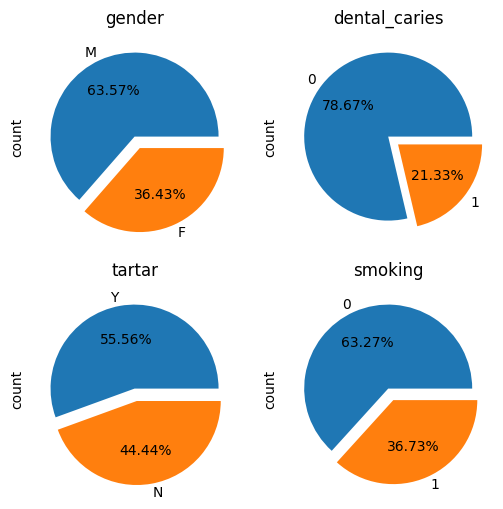

In [13]:
fig, axes =  plt.subplots(2, 2, figsize = (6, 6))
ax, axes = 0, axes.flatten()

def pie_plt(data):
    global ax
    data.value_counts().plot.pie(explode = [0, 0.15], autopct='%1.2f%%', ax=axes[ax]
                                 ).set(title = data.name)
    ax += 1
# df[['smoking', 'gender', 'urine_protein', 'dental_caries', 'tartar']].apply(pie_plt, axis=0)
df.select_dtypes(['int', 'object']).drop(columns=['age', 'height_cm', 'weight_kg']).apply(pie_plt, axis=0)

From pie chart of smoking, it is a unbalanced dataset

age               None
height_cm         None
weight_kg         None
urine_protein     None
eyesight_left     None
eyesight_right    None
dtype: object

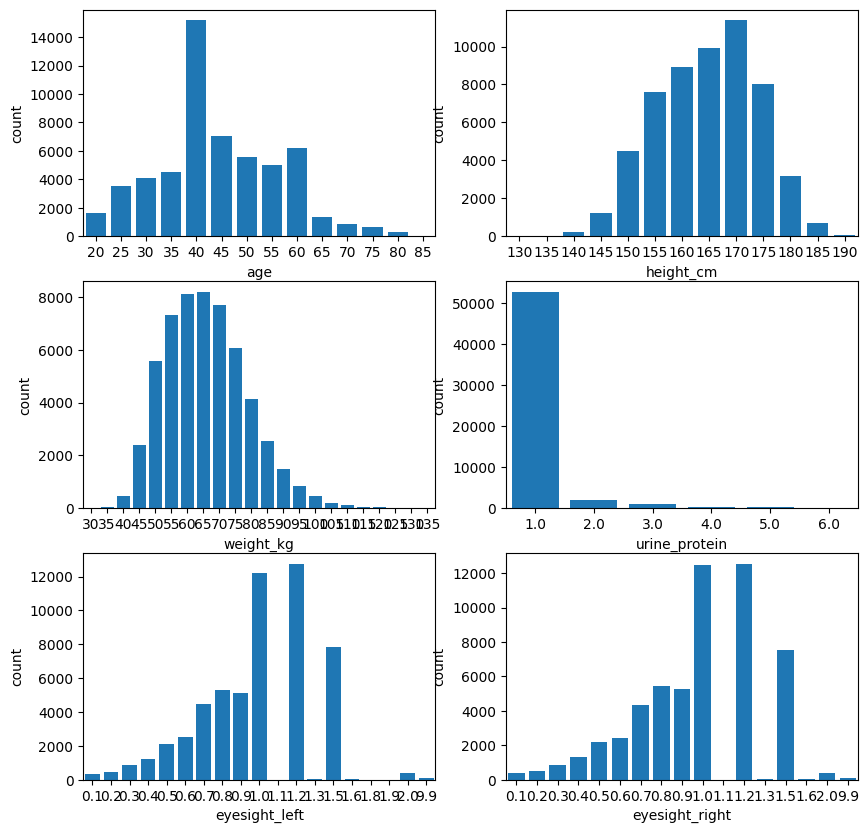

In [37]:
fig, axes = plt.subplots(3, 2, figsize = (10, 10))
ax, axes = 0, axes.flatten()

def bar_plt(data):
    global ax
    sns.barplot(ax = axes[ax],
                x = data.value_counts().index,
                y = data.value_counts(),
                saturation = 1)
    ax += 1
df[['age', 'height_cm', 'weight_kg', 'urine_protein', 'eyesight_left',
       'eyesight_right']].apply(bar_plt, axis=0)


In [15]:
df.select_dtypes('float').apply(np.unique, axis=0)

waist_cm               [51.0, 53.0, 54.0, 55.0, 56.0, 56.2, 56.4, 56....
eyesight_left          [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...
eyesight_right         [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...
hearing_left                                                  [1.0, 2.0]
hearing_right                                                 [1.0, 2.0]
systolic               [71.0, 72.0, 74.0, 79.0, 80.0, 81.0, 82.0, 83....
relaxation             [40.0, 42.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49....
fasting_blood_sugar    [46.0, 48.0, 51.0, 54.0, 55.0, 56.0, 57.0, 58....
cholesterol            [55.0, 72.0, 77.0, 84.0, 86.0, 87.0, 90.0, 91....
triglyceride           [8.0, 11.0, 15.0, 16.0, 19.0, 20.0, 21.0, 22.0...
hdl                    [4.0, 11.0, 14.0, 17.0, 18.0, 21.0, 22.0, 23.0...
ldl                    [1.0, 4.0, 7.0, 9.0, 10.0, 11.0, 12.0, 13.0, 1...
hemoglobin             [4.9, 5.0, 5.5, 5.8, 5.9, 6.1, 6.2, 6.3, 6.4, ...
urine_protein                             [1.0, 2.0

waist_cm               None
systolic               None
relaxation             None
fasting_blood_sugar    None
cholesterol            None
triglyceride           None
hdl                    None
ldl                    None
hemoglobin             None
serum_creatinine       None
ast                    None
alt                    None
gtp                    None
dtype: object

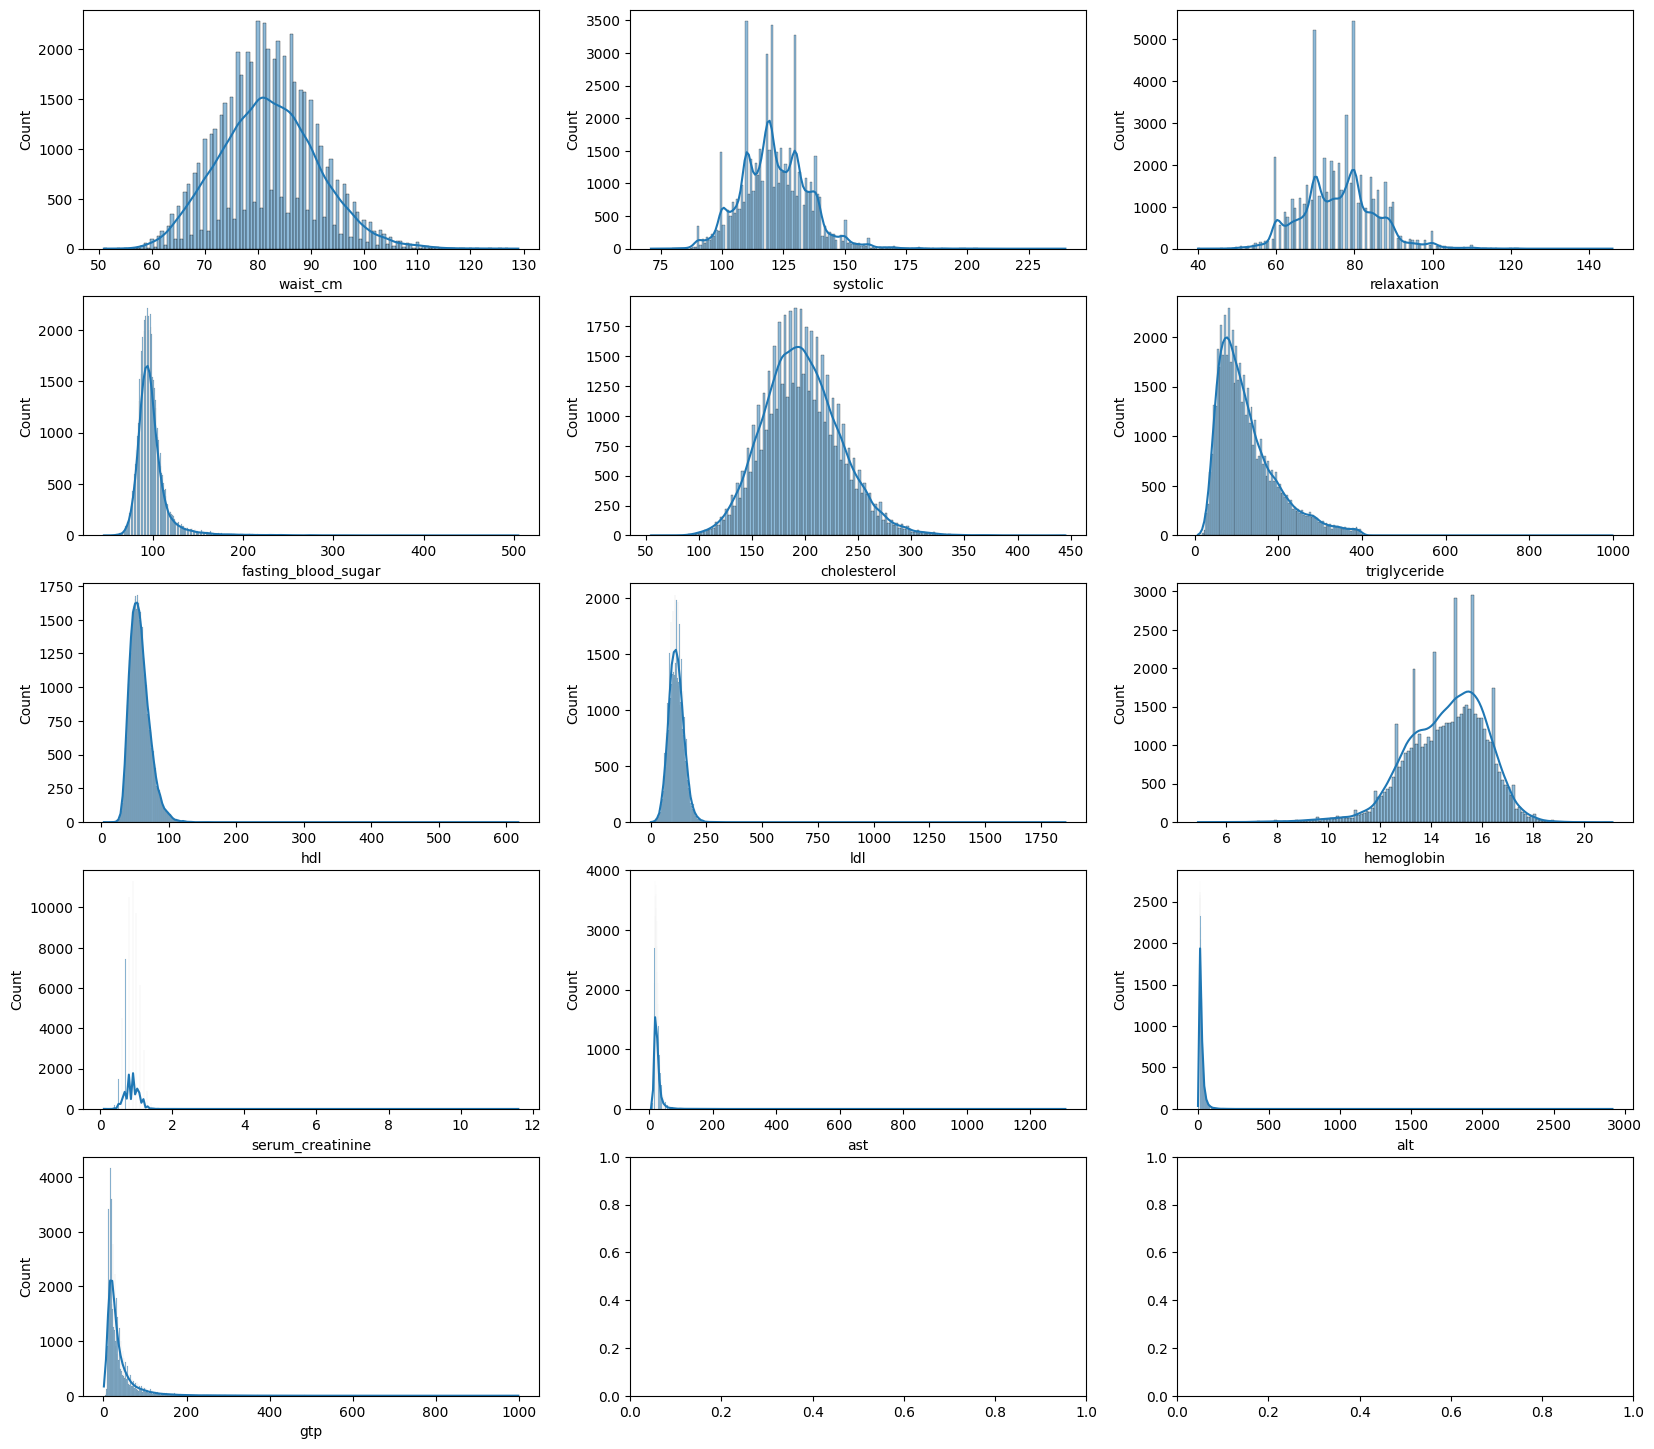

In [47]:
fig, axes = plt.subplots(5, 3, figsize = (20, 18))
ax, axes = 0, axes.flatten()

def hist_plt(data):
    global ax
    sns.histplot(ax=axes[ax],
                x=data, kde=True)
    ax += 1
df.select_dtypes('float').drop(columns=['hearing_left', 'hearing_right',
                                        'urine_protein', 
                                        'eyesight_left','eyesight_right']
                                ).apply(hist_plt, axis=0)

In [69]:
df = df.drop('oral', axis=1)
df['gender'] = df['gender'].map({'M':1, 'F':0})
df['tartar'] = df['tartar'].map({'Y':1, 'N':0})
df.head(3)

,gender,age,height_cm,weight_kg,waist_cm,eyesight_left,eyesight_right,hearing_left,hearing_right,systolic,...,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,dental_caries,tartar,smoking
0,0,40,155,60,81.3,1.2,1.0,1.0,1.0,114.0,...,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0,1,0
1,0,40,160,60,81.0,0.8,0.6,1.0,1.0,119.0,...,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0,1,0
2,1,55,170,60,80.0,0.8,0.8,1.0,1.0,138.0,...,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0,0,1


In [70]:
df.corr(# Pearson, linear relationship
    ).style.format('{:.2f}'
                   ).background_gradient(cmap = "Oranges"
                                         ).set_properties(**{'max-width': '111px', }) 

,gender,age,height_cm,weight_kg,waist_cm,eyesight_left,eyesight_right,hearing_left,hearing_right,systolic,relaxation,fasting_blood_sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,dental_caries,tartar,smoking
gender,1.00,-0.29,0.74,0.57,0.42,0.13,0.13,-0.01,-0.01,0.17,0.18,0.10,-0.09,0.24,-0.31,-0.04,0.70,0.02,0.51,0.10,0.17,0.24,0.08,0.06,0.51
age,-0.29,1.00,-0.48,-0.32,-0.03,-0.20,-0.19,0.20,0.21,0.13,0.05,0.18,0.06,0.02,0.01,0.04,-0.26,0.03,-0.11,0.03,-0.06,0.01,-0.11,-0.08,-0.16
height_cm,0.74,-0.48,1.00,0.68,0.38,0.15,0.16,-0.08,-0.08,0.08,0.11,0.02,-0.08,0.16,-0.21,-0.05,0.54,0.01,0.38,0.04,0.13,0.14,0.08,0.06,0.40
weight_kg,0.57,-0.32,0.68,1.00,0.82,0.11,0.11,-0.05,-0.05,0.27,0.27,0.14,0.03,0.32,-0.36,0.04,0.49,0.03,0.32,0.12,0.25,0.21,0.07,0.06,0.30
waist_cm,0.42,-0.03,0.38,0.82,1.00,0.03,0.04,0.02,0.02,0.32,0.29,0.21,0.07,0.36,-0.38,0.07,0.39,0.05,0.24,0.14,0.25,0.24,0.04,0.05,0.23
eyesight_left,0.13,-0.20,0.15,0.11,0.03,1.00,0.35,-0.05,-0.05,-0.02,0.01,-0.04,-0.00,0.02,-0.02,-0.01,0.10,-0.00,0.07,-0.01,0.02,0.00,0.00,0.01,0.06
eyesight_right,0.13,-0.19,0.16,0.11,0.04,0.35,1.00,-0.04,-0.05,-0.01,0.01,-0.04,-0.01,0.02,-0.02,-0.01,0.10,-0.01,0.05,-0.01,0.02,0.01,0.02,0.01,0.06
hearing_left,-0.01,0.20,-0.08,-0.05,0.02,-0.05,-0.04,1.00,0.51,0.06,0.01,0.04,-0.02,0.00,-0.02,-0.02,-0.03,0.01,0.00,0.02,0.00,0.01,-0.02,-0.04,-0.02
hearing_right,-0.01,0.21,-0.08,-0.05,0.02,-0.05,-0.05,0.51,1.00,0.05,0.00,0.04,-0.02,0.00,-0.02,-0.02,-0.03,0.02,0.01,0.01,-0.01,0.01,-0.02,-0.03,-0.02
systolic,0.17,0.13,0.08,0.27,0.32,-0.02,-0.01,0.06,0.05,1.00,0.76,0.17,0.06,0.20,-0.09,0.02,0.19,0.05,0.07,0.08,0.09,0.17,0.03,0.01,0.07


From the correlation heatmap, smoking has a closer linear correlation with gender(0.51), hemoglobin(0.40), height(0.40), weight(0.30). 


However, according to common sence, height should not be one of factors to smoking. It can seen that height has a closer linear correlation with gender(0.74), weight(0.68), hemoglobin(0.54) which are much related to smoking. $\impliedby$ **Guess 1 Colinear Problem exists.**

### gender

array([<Axes: ylabel='No smoking'>, <Axes: ylabel='Smoking'>],
      dtype=object)

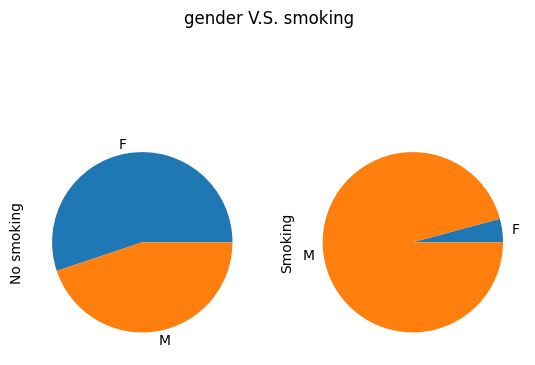

In [71]:
plt.style.use('default')

pd.crosstab(df['gender'].map({0:'F', 1:'M'}), df['smoking'].map({0: 'No smoking', 1:'Smoking'})
            ).plot(kind='pie', subplots=True, stacked=True, title='gender V.S. smoking', legend=False )

### hemoglobin：血红蛋白含量

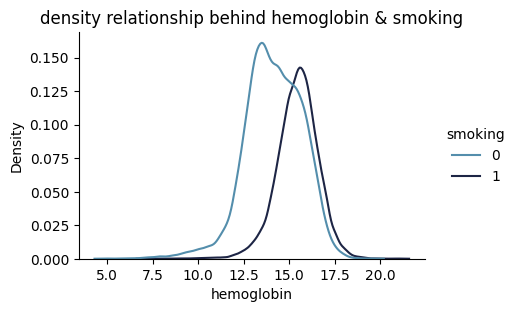

In [72]:
sns.displot(
    data=df, x='hemoglobin', hue='smoking',
    kind='kde', height=3, aspect=1.5,
    palette="ch:rot=-.25,hue=1,light=.50"
).set(title='density relationship behind hemoglobin & smoking')

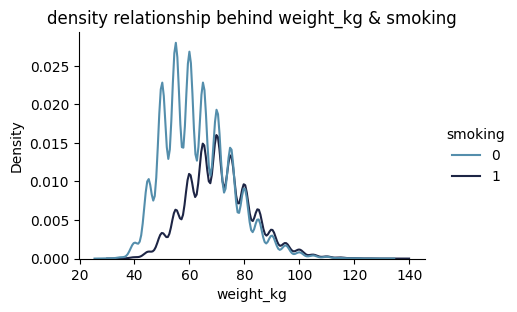

In [73]:
sns.displot(
    data=df, x='weight_kg', hue='smoking', 
    kind='kde', height=3, aspect=1.5,
    palette="ch:rot=-.25,hue=1,light=.50"
).set(title='density relationship behind weight_kg & smoking')

💡 Observation: Average waist size of a smoker is more than a non-smoker

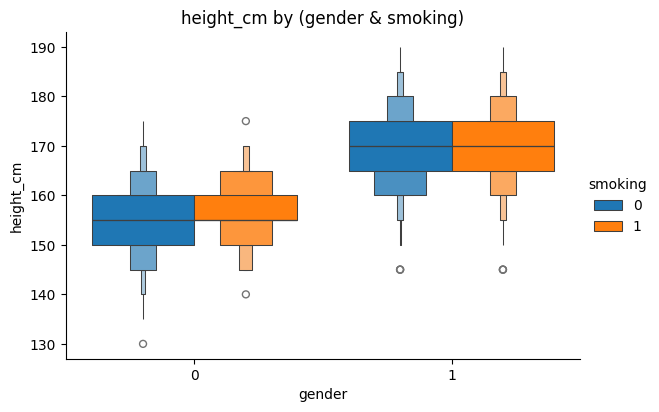

In [74]:
sns.catplot(data=df, x='gender', y='height_cm', hue='smoking',
            kind='boxen', saturation=1, height=4, aspect=1.5 
            ).set(title='height_cm by (gender & smoking)')
# 中位数 = 

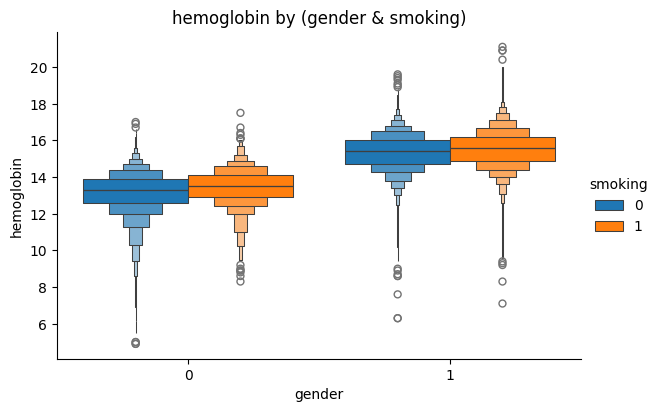

In [75]:
sns.catplot(data=df, x='gender', y='hemoglobin', hue='smoking',
            kind='boxen', saturation=1, height=4, aspect=1.5 
            ).set(title='hemoglobin by (gender & smoking)')

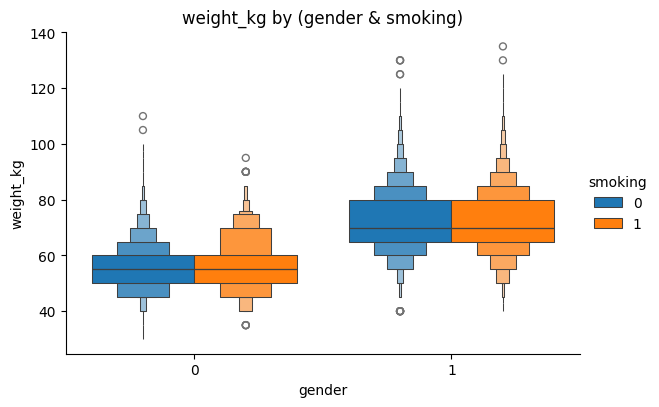

In [76]:
sns.catplot(data=df, x='gender', y='weight_kg', hue='smoking',
            kind='boxen', saturation=1, height=4, aspect=1.5 
            ).set(title='weight_kg by (gender & smoking)')

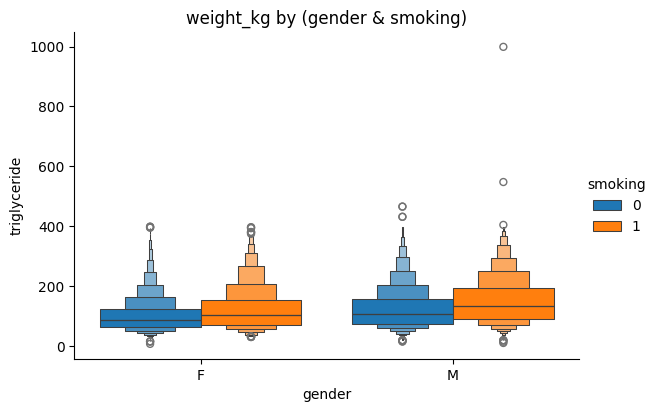

In [353]:
sns.catplot(data=df, x='gender', y='triglyceride', hue='smoking',
            kind='boxen', saturation=1, height=4, aspect=1.5 
            ).set(title='weight_kg by (gender & smoking)')

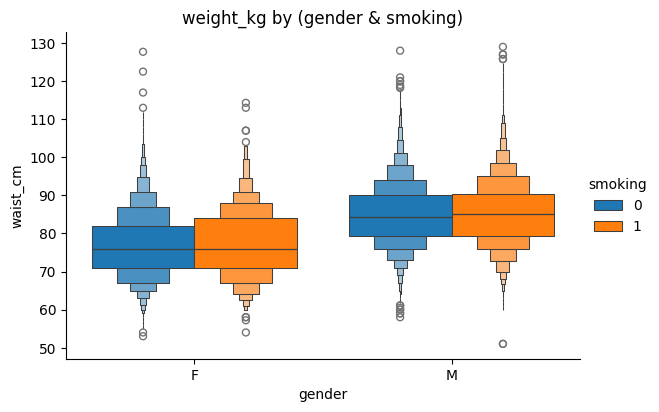

In [359]:

sns.catplot(data=df, x='gender', y='waist_cm', hue='smoking',
            kind='boxen', saturation=1, height=4, aspect=1.5 
            ).set(title='weight_kg by (gender & smoking)')

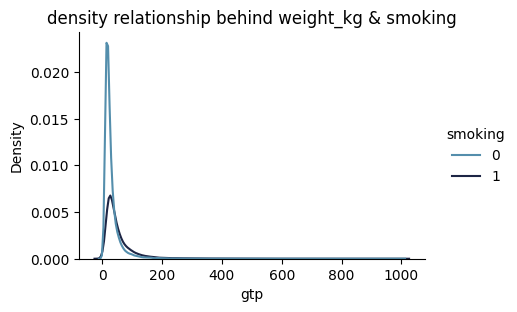

In [292]:
sns.displot(
    data=df, x='gtp', hue='smoking', 
    kind='kde', height=3, aspect=1.5,
    palette="ch:rot=-.25,hue=1,light=.50"
).set(title='density relationship behind weight_kg & smoking')

## Pre-processing

1. dropNA
2. drop duplicate
3. drop outliers
   1.  for variables which follow normal distribution, using 3*std
   2.  for variables, using 1.5*IQR
4. encode categorical features
5. 

### Outlier detection
https://blog.csdn.net/qq_41810188/article/details/108243609

In [185]:
df.columns

Index(['gender', 'age', 'height_cm', 'weight_kg', 'waist_cm', 'eyesight_left',
       'eyesight_right', 'hearing_left', 'hearing_right', 'systolic',
       'relaxation', 'fasting_blood_sugar', 'cholesterol', 'triglyceride',
       'hdl', 'ldl', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'ast',
       'alt', 'gtp', 'dental_caries', 'tartar', 'smoking'],
      dtype='object')

In [188]:
def detect_outliers_using_std(data, columns):
    all_drop_rows = set()
    for col in columns:
        mu, sigma =  data[col].mean(), data[col].std() 
        lower = mu - 3 * sigma
        upper = mu + 3 * sigma
        idxes = data[(data[col] < lower) | (data[col] > upper)].index
        all_drop_rows.update(idxes)
        print(f'{len(idxes)}  of {col} has which are smaller than {lower} or larger than {upper} ')
    print(f'{len(all_drop_rows)} outliers')
    return list(all_drop_rows)

all_drop_rows1 = detect_outliers_using_std(df, ['waist_cm', 'fasting_blood_sugar', 'cholesterol', 'hdl', 'ldl'])

240  of waist_cm has which are smaller than 54.223749513114406 or larger than 109.86908608266239 
992  of fasting_blood_sugar has which are smaller than 36.92555111539122 or larger than 161.69909874455277 
296  of cholesterol has which are smaller than 88.00760084270298 or larger than 305.79524337190594 
481  of hdl has which are smaller than 13.073458574629967 or larger than 101.50723524135796 
96  of ldl has which are smaller than -7.814928145959158 or larger than 237.743930516138 
1993 outliers


In [189]:
def detect_outliers_using_IQR(data, columns):
    all_drop_rows = set()
    for col in columns:
        Q1, Q3 = np.nanpercentile(data[col], 25), np.nanpercentile(data[col], 75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        idxes = data[(data[col] < lower) | (data[col] > upper)].index
        all_drop_rows.update(idxes)
        print(f'{len(idxes)}  of {col} has which are smaller than {lower} or larger than {upper} ')
    print(f'{len(all_drop_rows)} outliers')
    return list(all_drop_rows)

all_drop_rows2 = detect_outliers_using_IQR(df, ['height_cm', 'weight_kg','systolic','relaxation',])

249  of height_cm has which are smaller than 145.0 or larger than 185.0 
198  of weight_kg has which are smaller than 25.0 or larger than 105.0 
685  of systolic has which are smaller than 85.0 or larger than 157.0 
706  of relaxation has which are smaller than 52.0 or larger than 100.0 
1540 outliers


In [190]:
df_drop_12 = df.drop(all_drop_rows1+all_drop_rows2, axis=0)

In [191]:
df_drop_12

,gender,age,height_cm,weight_kg,waist_cm,eyesight_left,eyesight_right,hearing_left,hearing_right,systolic,...,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,dental_caries,tartar,smoking
0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,114.0,...,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0,Y,0
1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,119.0,...,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0,Y,0
2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,138.0,...,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0,N,1
4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,120.0,...,107.0,12.5,1.0,0.6,16.0,14.0,22.0,0,N,0
5,M,30,180,75,85.0,1.2,1.2,1.0,1.0,128.0,...,129.0,16.2,1.0,1.2,18.0,27.0,33.0,0,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55687,F,40,170,65,75.0,0.9,0.9,1.0,1.0,110.0,...,118.0,12.3,1.0,0.6,14.0,7.0,10.0,1,Y,0
55688,F,45,160,50,70.0,1.2,1.2,1.0,1.0,101.0,...,79.0,14.0,1.0,0.9,20.0,12.0,14.0,0,Y,0
55689,F,55,160,50,68.5,1.0,1.2,1.0,1.0,117.0,...,63.0,12.4,1.0,0.5,17.0,11.0,12.0,0,N,0
55690,M,60,165,60,78.0,0.8,1.0,1.0,1.0,133.0,...,146.0,14.4,1.0,0.7,20.0,19.0,18.0,0,N,0


### Encode Categoric Variables

In [192]:
df_drop_12['gender'] = df_drop_12['gender'].map({'M':1, 'F':0})
df_drop_12['tartar'] = df_drop_12['tartar'].map({'Y':1, 'N':0})

In [193]:
df_drop_12

,gender,age,height_cm,weight_kg,waist_cm,eyesight_left,eyesight_right,hearing_left,hearing_right,systolic,...,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,dental_caries,tartar,smoking
0,0,40,155,60,81.3,1.2,1.0,1.0,1.0,114.0,...,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0,1,0
1,0,40,160,60,81.0,0.8,0.6,1.0,1.0,119.0,...,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0,1,0
2,1,55,170,60,80.0,0.8,0.8,1.0,1.0,138.0,...,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0,0,1
4,0,40,155,60,86.0,1.0,1.0,1.0,1.0,120.0,...,107.0,12.5,1.0,0.6,16.0,14.0,22.0,0,0,0
5,1,30,180,75,85.0,1.2,1.2,1.0,1.0,128.0,...,129.0,16.2,1.0,1.2,18.0,27.0,33.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55687,0,40,170,65,75.0,0.9,0.9,1.0,1.0,110.0,...,118.0,12.3,1.0,0.6,14.0,7.0,10.0,1,1,0
55688,0,45,160,50,70.0,1.2,1.2,1.0,1.0,101.0,...,79.0,14.0,1.0,0.9,20.0,12.0,14.0,0,1,0
55689,0,55,160,50,68.5,1.0,1.2,1.0,1.0,117.0,...,63.0,12.4,1.0,0.5,17.0,11.0,12.0,0,0,0
55690,1,60,165,60,78.0,0.8,1.0,1.0,1.0,133.0,...,146.0,14.4,1.0,0.7,20.0,19.0,18.0,0,0,0


In [194]:
x_cols = list(df_drop_12.columns)
x_cols.remove('smoking')
y, X = df_drop_12['smoking'], df_drop_12[x_cols]
print(y.shape, X.shape)

(52355,) (52355, 24)


#### Split

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
print(X_train.shape, X_test.shape)

(47119, 24) (5236, 24)


In [232]:
def performace(classifier ):
    y_pred = classifier.predict(X_train)
    print(f'Accuracy on traning data: {accuracy_score(y_train, y_pred)}')
    y_pred = classifier.predict(X_test)
    print(f'Accuracy on testing data: {accuracy_score(y_test, y_pred)}')
    return

def build_model(classifier):
    print(f'{classifier}:')
    classifier.fit(X_train, y_train)
    performace(classifier)
    return classifier

def tune_model(classifier, param_grid):

    grid_search = GridSearchCV(classifier, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best = grid_search.best_estimator_
    print(grid_search.cv_results_['params'])
    print(grid_search.cv_results_['mean_test_score'])
    print(best)
    performace(best)
    return best

### Oversampling strategy

In [206]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

#### original

In [207]:
# standalization
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

In [208]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
print(f'Accuracy on traning data: {accuracy_score(y_train, y_pred)}')
y_pred = lr.predict(X_test)
print(f'Accuracy on testing data: {accuracy_score(y_test, y_pred)}')

Accuracy on traning data: 0.7425030242577304
Accuracy on testing data: 0.7402597402597403


#### SMOTE

In [210]:
smovs = SMOTE(sampling_strategy = "auto", random_state=SEED, k_neighbors = 5, n_jobs = -1)
X_smote, y_smote = smovs.fit_resample(X_train, y_train)

lr_smote = LogisticRegression()
lr_smote.fit(X_smote, y_smote)
performace(lr_smote)

Accuracy on traning data: 0.7174176022411342
Accuracy on testing data: 0.712375859434683


### Features selection

#### PCA

In [258]:
from sklearn.decomposition import PCA

In [263]:
pca_default = PCA(random_state=SEED, svd_solver='randomized' )
print(pca_default)
X_train_pca = pca_default.fit_transform(X_train)
X_test_pca = pca_default.transform(X_test)

lr_pca = LogisticRegression()
lr_pca.fit(X_train_pca, y_train)

y_pred = lr_pca.predict(X_train_pca)
print(f'Accuracy on traning data: {accuracy_score(y_train, y_pred)}')
y_pred = lr_pca.predict(X_test_pca)
print(f'Accuracy on testing data: {accuracy_score(y_test, y_pred)}')

PCA(random_state=123, svd_solver='randomized')
Accuracy on traning data: 0.7419724527260765
Accuracy on testing data: 0.7406417112299465


In [280]:
pca_default = PCA(random_state=SEED, svd_solver='randomized', n_components=14 )
print(pca_default)
print(pca_default.components_)
X_train_pca = pca_default.fit_transform(X_train)
X_test_pca = pca_default.transform(X_test)

lr_pca = LogisticRegression()
lr_pca.fit(X_train_pca, y_train)

y_pred = lr_pca.predict(X_train_pca)
print(f'Accuracy on traning data: {accuracy_score(y_train, y_pred)}')
y_pred = lr_pca.predict(X_test_pca)
print(f'Accuracy on testing data: {accuracy_score(y_test, y_pred)}')


PCA(n_components=14, random_state=123, svd_solver='randomized')
Accuracy on traning data: 0.7325282794626371
Accuracy on testing data: 0.7379679144385026


#### LDA


In [312]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)


lr_lda = LogisticRegression()
lr_lda.fit(X_train_lda, y_train)

y_pred = lr_lda.predict(X_train_lda)
print(f'Accuracy on traning data: {accuracy_score(y_train, y_pred)}')
y_pred = lr_lda.predict(X_test_lda)
print(f'Accuracy on testing data: {accuracy_score(y_test, y_pred)}')

Accuracy on traning data: 0.7426940300091258
Accuracy on testing data: 0.7421695951107716


In [313]:
dict(zip(list(df_drop_12.columns),lda.coef_[0])) #0.7440310702688937 0.7421695951107716

{'gender': 2.5660870028357605,
 'age': 0.04592528347324226,
 'height_cm': 0.9183546411576677,
 'weight_kg': -0.9023702772583954,
 'waist_cm': -0.09155390793051685,
 'eyesight_left': -0.18168218071387776,
 'eyesight_right': -0.07260088031243953,
 'hearing_left': -0.21929129508495088,
 'hearing_right': 0.007595805665277991,
 'systolic': -1.0714954437068793,
 'relaxation': 0.5056624299088083,
 'fasting_blood_sugar': 0.34466856685473973,
 'cholesterol': -1.8122955338474467,
 'triglyceride': 3.0768349091112306,
 'hdl': 0.7190501099251454,
 'ldl': 1.3263232378329584,
 'hemoglobin': 1.938966165188531,
 'urine_protein': 0.10125065726148748,
 'serum_creatinine': -7.575044642106974,
 'ast': -3.7478596320520463,
 'alt': -4.883968678011814,
 'gtp': 6.2855274152625285,
 'dental_caries': 0.35172983020988147,
 'tartar': 0.3294992334195125}

#### T-SNE


In [317]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=123)  
X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.fit_transform(X_test)

In [320]:
lr_tsne = LogisticRegression()
lr_tsne.fit(X_train_tsne, y_train)

y_pred = lr_tsne.predict(X_train_tsne)
print(f'Accuracy on traning data: {accuracy_score(y_train, y_pred)}')
y_pred = lr_tsne.predict(X_test_tsne)
print(f'Accuracy on testing data: {accuracy_score(y_test, y_pred)}')

Accuracy on traning data: 0.6904008998493177
Accuracy on testing data: 0.6621466768525592


#### Drop manually


In [272]:
df_drop_12.columns

Index(['gender', 'age', 'height_cm', 'weight_kg', 'waist_cm', 'eyesight_left',
       'eyesight_right', 'hearing_left', 'hearing_right', 'systolic',
       'relaxation', 'fasting_blood_sugar', 'cholesterol', 'triglyceride',
       'hdl', 'ldl', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'ast',
       'alt', 'gtp', 'dental_caries', 'tartar', 'smoking'],
      dtype='object')

In [273]:
x_cols = list(df_drop_12.columns)
x_cols.remove('smoking')
x_cols.remove('height_cm')
y, X = df_drop_12['smoking'], df_drop_12[x_cols]
print(y.shape, X.shape)

(52355,) (52355, 23)


In [274]:
X_train_height, X_test_height, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
print(X_train_height.shape, X_test_height.shape)
# standalization
scaler = MinMaxScaler()
scaler.fit(X_train_height)
X_train_height, X_test_height = scaler.transform(X_train_height), scaler.transform(X_test_height)

(47119, 23) (5236, 23)


In [277]:
lr = LogisticRegression()
lr.fit(X_train_height, y_train)
y_pred = lr.predict(X_train_height)
print(f'Accuracy on traning data: {accuracy_score(y_train, y_pred)}')
y_pred = lr.predict(X_test_height)
print(f'Accuracy on testing data: {accuracy_score(y_test, y_pred)}')

Accuracy on traning data: 0.7423969099513996
Accuracy on testing data: 0.7427425515660809


In [388]:
y, X = df_drop_12['smoking'], np.array(df_drop_12[['gender']])

print(y.shape, X.shape)
X_train_gender, X_test_gender, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
print(X_train_gender.shape, X_test_gender.shape)
scaler = MinMaxScaler()
scaler.fit(X_train_gender)
X_train_gender, X_test_gender = scaler.transform(X_train_gender), scaler.transform(X_test_gender)


(52355,) (52355, 1)
(47119, 1) (5236, 1)


In [389]:
# ['gender']
lr = LogisticRegression(random_state=SEED)
lr.fit(X_train_gender, y_train)
y_pred = lr.predict(X_train_gender)
print(f'Accuracy on traning data: {accuracy_score(y_train, y_pred)}')
y_pred = lr.predict(X_test_gender)
print(f'Accuracy on testing data: {accuracy_score(y_test, y_pred)}')

Accuracy on traning data: 0.6972346611770199
Accuracy on testing data: 0.6986249045072574


In [387]:
# ['gender','hemoglobin']
lr = LogisticRegression(random_state=SEED)
lr.fit(X_train_gender, y_train)
y_pred = lr.predict(X_train_gender)
print(f'Accuracy on traning data: {accuracy_score(y_train, y_pred)}')
y_pred = lr.predict(X_test_gender)
print(f'Accuracy on testing data: {accuracy_score(y_test, y_pred)}')

Accuracy on traning data: 0.6986990386043846
Accuracy on testing data: 0.7020626432391138


In [385]:
# ['gender','hemoglobin', 'triglyceride' ]
lr = LogisticRegression(random_state=SEED)
lr.fit(X_train_gender, y_train)
y_pred = lr.predict(X_train_gender)
print(f'Accuracy on traning data: {accuracy_score(y_train, y_pred)}')
y_pred = lr.predict(X_test_gender)
print(f'Accuracy on testing data: {accuracy_score(y_test, y_pred)}')

Accuracy on traning data: 0.7196247798128144
Accuracy on testing data: 0.7215431627196333


In [381]:
# ['gender','hemoglobin', 'triglyceride','gtp' ]
lr = LogisticRegression(random_state=SEED)
lr.fit(X_train_gender, y_train)
y_pred = lr.predict(X_train_gender)
print(f'Accuracy on traning data: {accuracy_score(y_train, y_pred)}')
y_pred = lr.predict(X_test_gender)
print(f'Accuracy on testing data: {accuracy_score(y_test, y_pred)}')

Accuracy on traning data: 0.7278168042615505
Accuracy on testing data: 0.7347211611917495


## Model Building

### Logistic Regression

https://blog.csdn.net/lc574260570/article/details/82116197

In [211]:
from sklearn.linear_model import LogisticRegression

In [245]:
lr_default = LogisticRegression(random_state=SEED) # l2
lr_default = build_model(lr_default)

LogisticRegression(random_state=123):
Accuracy on traning data: 0.7425030242577304
Accuracy on testing data: 0.7402597402597403


In [246]:
lr_saga = LogisticRegression(solver='saga', penalty='l1', random_state=SEED) # l1
lr_saga = build_model(lr_saga)

LogisticRegression(penalty='l1', random_state=123, solver='saga'):
Accuracy on traning data: 0.7439886245463614
Accuracy on testing data: 0.741405653170359


In [255]:
lr_l1 = LogisticRegression(solver='liblinear', penalty='l1', random_state=SEED) # l1
lr_l1 = build_model(lr_l1)

LogisticRegression(penalty='l1', random_state=123, solver='liblinear'):
Accuracy on traning data: 0.7440310702688937
Accuracy on testing data: 0.7421695951107716


In [256]:
lr_l2 = LogisticRegression(solver='liblinear', penalty='l2', random_state=SEED) # l1
lr_l2 = build_model(lr_l2)

LogisticRegression(random_state=123, solver='liblinear'):
Accuracy on traning data: 0.7418663384197457
Accuracy on testing data: 0.7402597402597403


**Bagging & Boosting**

Bagging is a method of merging the same type of predictions. Bagging decreases variance, not bias, and solves over-fitting issues in a model.

Boosting is a method of merging different types of predictions. Boosting decreases bias, not variance.

### Random Forest

#### Params
- `n_estimators: int = 100`
  
    The number of trees in the forest

- `criterion : {"gini", "entropy", "log_loss"} = "gini"`
  
    The function to measure the quality of a split.
    
- `max_depth : int, default=None`
  
    The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

- `class_weight : {"balanced", "balanced_subsample"}, dict or list of dicts, = None`

    Weights associated with classes in the form `{class_label: weight}`. 

    - If not given, all classes are supposed to have weight 1. 
    
    - Note that for multioutput (including multilabel) weights should be defined for each class of every column in its own dict. For example, for four-class multilabel classification weights should be `[{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 1}, {0: 1, 1: 1}]` instead of [{1:1}, {2:5}, {3:1}, {4:1}].

    - `"balanced"` mode uses the values of y to automatically adjust weights inversely proportional to class **frequencies** in the input data as $\cfrac{n_{samples} }{ (n_{classes} * \text{np.bincount(y)})}$

    - `"balanced_subsample"` mode is the same as "balanced" except that weights are computed based on the bootstrap sample for every tree grown.
- `oob_score : bool or callable, default=False`
        
    Whether to use out-of-bag samples to estimate the generalization score. 
    
    - `default`, :func:`~sklearn.metrics.accuracy_score` is used. 

ref:
- [scikit-learn随机森林类库概述](https://www.cnblogs.com/pinard/p/6160412.html)
- source code

In [238]:
# baseline
rf = RandomForestClassifier(random_state=SEED)
rf_default = build_model(rf)

RandomForestClassifier(random_state=123):
Accuracy on traning data: 0.9999787771387338
Accuracy on testing data: 0.8382352941176471


In [239]:
# Tuning `class_weight`
rf = RandomForestClassifier(random_state=SEED)
rf_param_grid = {
    'class_weight': [None, 'balanced']
}
rf_best1 = tune_model(rf, rf_param_grid)

[{'class_weight': None}, {'class_weight': 'balanced'}]
[0.82529339 0.82278908]
RandomForestClassifier(random_state=123)
Accuracy on traning data: 0.9999787771387338
Accuracy on testing data: 0.8382352941176471


Obviously the RF is **overfitting** because of its extremely high training accuracy & comparably much smaller testing accuracy.

To prevent overfitting and make RF more generalized, choosing **a smaller depth** to cut the tree early and **a larger amount of estimators** is considered.

In [240]:
# Tuning `max_depth` = None
rf = RandomForestClassifier(random_state=SEED)
rf_param_grid = {
    'max_depth': [30, 35, 40],
}
rf_best2 = tune_model(rf, rf_param_grid)

[{'max_depth': 30}, {'max_depth': 35}, {'max_depth': 40}]
[0.82654556 0.8252934  0.8251236 ]
RandomForestClassifier(max_depth=30, random_state=123)
Accuracy on traning data: 0.9999787771387338
Accuracy on testing data: 0.8359434682964094


In [395]:
# Tuning `n_estimators` = 100 
rf = RandomForestClassifier(max_depth=30, random_state=SEED)
rf_param_grid = {
    'n_estimators': [150, 200, 250],
}
rf_best3 = tune_model(rf, rf_param_grid)

[{'n_estimators': 150}, {'n_estimators': 200}, {'n_estimators': 250}]
[0.82709736 0.82637576 0.82813723]
RandomForestClassifier(max_depth=30, n_estimators=250, random_state=123)
Accuracy on traning data: 1.0
Accuracy on testing data: 0.8449197860962567


In [394]:
# Tuning `n_estimators` = 100 
rf = RandomForestClassifier(max_depth=30, random_state=SEED)
rf_param_grid = {
    'n_estimators': [300, 350, 400],
}
rf_best3 = tune_model(rf, rf_param_grid)

[{'n_estimators': 300}, {'n_estimators': 350}, {'n_estimators': 400}]
[0.82822214 0.82926211 0.82879522]
RandomForestClassifier(max_depth=30, n_estimators=350, random_state=123)
Accuracy on traning data: 1.0
Accuracy on testing data: 0.8460656990068754


In [398]:
# Tuning `n_estimators` = 100 
rf = RandomForestClassifier(max_depth=30, random_state=SEED,n_estimators=350)
rf_param_grid = {
    'min_samples_split':[5, 10], 
    'min_samples_leaf':[5]
    }
rf_best3 = tune_model(rf, rf_param_grid)

[{'min_samples_leaf': 5, 'min_samples_split': 5}, {'min_samples_leaf': 5, 'min_samples_split': 10}]
[0.81338741 0.81338741]
RandomForestClassifier(max_depth=30, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=350, random_state=123)
Accuracy on traning data: 0.9640484730151319
Accuracy on testing data: 0.825057295645531


In [401]:
# Tuning `n_estimators` = 100 
rf = RandomForestClassifier(max_depth=30, random_state=SEED,n_estimators=350)
rf_param_grid = {
    'min_samples_split':[5], 
    'min_samples_leaf':[2, 4]
    }
rf_best3 = tune_model(rf, rf_param_grid)

[{'min_samples_leaf': 2, 'min_samples_split': 5}, {'min_samples_leaf': 4, 'min_samples_split': 5}]
[0.82408372 0.82009388]
RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=350, random_state=123)
Accuracy on traning data: 0.9914684097710054
Accuracy on testing data: 0.8409090909090909


In [ ]:
rf_best3.feature_importances_ 

In [ ]:
importance = pd.DataFrame({"Importance": rf_best3.feature_importances_ * 100},
                         index = pd.DataFrame(x_train).columns)
importance.sort_values(by = "Importance", axis = 0,
                       ascending = True).plot(kind = "bar", color = "red")
plt.xlabel("Importance levels of the variables")
plt.ylabel("Variables");

In [390]:
rf_final = RandomForestClassifier(max_depth=30, min_samples_split=5, min_samples_leaf=2, n_estimators=300)

rf_final = build_model(rf_final)

RandomForestClassifier(max_depth=35, min_samples_leaf=5, min_samples_split=80,
                       n_estimators=300):
Accuracy on traning data: 0.8518432055009656
Accuracy on testing data: 0.7868601986249045


### Xgboost

In [143]:
from xgboost import XGBClassifier

In [166]:
xgb_default = XGBClassifier(random_state=SEED)
xgb_default = build_model(xgb_default)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...):
Accuracy on traning data: 0.8611388187355419
Accuracy on testing data: 0.7794117647058824


In [264]:
from sklearn.ensemble import GradientBoostingClassifier # 导入梯度提升分类器类

In [266]:
gbdt = GradientBoostingClassifier(random_state=123)
gbdt = build_model(gbdt)


GradientBoostingClassifier(random_state=123):
Accuracy on traning data: 0.7718966871113564
Accuracy on testing data: 0.7647058823529411


### comparison

In [152]:
x = PrettyTable()
print('\n')
print("Performance Comparison")
x.field_names = ["Model", "Accuracy"]

x.add_row(["xgb_default", round(accuracy_score(y_test, xgb_default.predict(X_test)), 2)])
x.add_row(["rf_default", round(accuracy_score(y_test, rf_default.predict(X_test)), 3)])

print(x)
print('\n')



Performance Comparison
+-------------+----------+
|    Model    | Accuracy |
+-------------+----------+
| xgb_default |   0.83   |
|  rf_default |  0.847   |
+-------------+----------+




Key Findings:

Hemoglobin levels are high in smokers
Smoking is more prevalent among younger individuals
The male population has a higher representation among smokers compared to females as per the dataset
Triglyceride levels seems to be higher in smokers as compared to non-smokers